
- Cover: Problem → Data → Baselines → Advanced model → Training → Results → Ablations → Stress test → Ultimate judgment → How to run on AWS.


In [1]:
!pip install -U "tensorflow[and-cuda]==2.19.1" "keras==3.6.0" "ml-dtypes==0.5.1" "tensorflow-text==2.19.0" keras-hub --only-binary=:all: -q
print("Installation Done")

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-runtime-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-runtime-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system 

# <div align="center"> <font>Bridging Language and Vision: Deep Learning for Entailment Prediction (Visual Entailment)</font></div>

## Introduction
This project is organised into two stages: the baseline task builds a multimodal model for visual–textual entailment, and the enhancement task strengthens cross-modal reasoning with cross-attention. The goal is to decide whether a hypothesis sentence is entailed or contradicted by a premise image, without using any premise sentence as input.

In the baseline, visual features are obtained from EfficientNetB0 and textual embeddings from a BERT backbone. We adopt a staged training procedure: (1) initialise with both backbones frozen to stabilise fusion; (2) selectively unfreeze the top ~30% of EfficientNet layers (while keeping BatchNorm frozen) and the last N transformer blocks of BERT; and (3) fine-tune with a low learning rate. The fused representation uses simple concatenation followed by a compact MLP and a sigmoid classifier for binary entailment vs. contradiction.

In the enhancement stage, we introduce a cross-attention module that allows token-level BERT representations to attend to spatial image features, enabling finer alignment between entities and visual regions. This replaces naïve concatenation with learned interactions, aiming to reduce failure cases where simple fusion cannot capture subtle visual–textual correspondences.

By combining robust pretrained encoders with controlled unfreezing and advancing from concat fusion to cross-attention, the project delivers a practical and extensible framework for visual–textual entailment under the constraint of image-only premises.

### Importing Libraries and Setting up environment 

In [2]:
# === 0. Imports, config, seeds ===
import os, json, glob, random, math
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

2025-10-07 00:13:20.499426: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-07 00:13:20.665360: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759796000.686028   10238 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759796000.692249   10238 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1759796000.707941   10238 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
#setting random seed
seed = 42 
random.seed(seed)

#setting seed for NumPy
np.random.seed(seed)

#setting seed for TensorFlow
tf.random.set_seed(seed)

#setting seed for full reproducibility
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 1


In [4]:
# Automatically tunes performance for data pipelines in TensorFlow
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Set style and context for larger labels and a cleaner look
sns.set(style="whitegrid")

# Define a color palette
palette = sns.color_palette("Blues_d")

### Loading Data
This first section of code is about loading and aligning the dataset so that each hypothesis sentence can be paired with the correct image and label. The dataset is stored in JSONL or JSON format, and the images are kept in a folder structure with .jpg, .jpeg, or .png extensions. The functions here take care of reading the annotations, scanning the image directory, mapping image IDs to file paths, and converting string labels (like “entailment” or “contradiction”) into binary numeric labels. Finally, the code filters out any rows whose images are missing, builds a clean record list, and turns it into a Pandas DataFrame for easier exploration and modeling. This preprocessing step ensures that the data is structured consistently for downstream model training.

In [5]:
# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# Paths
DATA_FILE = "A2_train_v3.jsonl"   # or .json
IMG_ROOT  = "A2_Images"

# Hyperparams
IMG_SIZE   = (224, 224)
BATCH      = 32
MAX_TOKENS = 32
MAX_VOCAB  = 20000

# Labels
LABEL_MAP = {"entailment": 1, "contradiction": 0}

In [6]:
# === 1. Load JSONL/JSON and map images ===
def read_rows(path):
    if path.endswith(".jsonl"):
        with open(path, "r", encoding="utf-8") as f:
            return [json.loads(l) for l in f if l.strip()]
    else:
        with open(path, "r", encoding="utf-8") as f:
            data = json.load(f)
            return data if isinstance(data, list) else data.get("rows", [])

# support .jpg/.jpeg/.png
def build_id_to_path(images_dir):
    id2p = {}
    for ext in ("*.jpg","*.jpeg","*.png"):
        for p in glob.glob(os.path.join(images_dir, "**", ext), recursive=True):
            img_id = os.path.splitext(os.path.basename(p))[0]
            id2p[img_id] = p
    return id2p

def lab2id(lbl):
    return 1 if "entail" in str(lbl).lower() else 0

rows = read_rows(DATA_FILE)
id2path = build_id_to_path(IMG_ROOT)

# align & filter
recs = []
missing = 0
for r in rows:
    img_id = r["Image_ID"]
    p = id2path.get(img_id)
    if p is None:
        missing += 1
        continue
    recs.append({
        "image_id": img_id,
        "path": p,
        "hypo": r["Hypothesis"],
        "y": lab2id(r["Label"])
    })
print(f"Loaded rows: {len(rows)} | usable: {len(recs)} | missing images: {missing}")

df = pd.DataFrame(recs)
df.head()


Loaded rows: 39129 | usable: 39129 | missing images: 0


,image_id,path,hypo,y
0,4564320256,A2_Images/4564320256.jpg,The old woman and a girl are bored.,1
1,4564320256,A2_Images/4564320256.jpg,Two old men robbing a convenience store.,0
2,4564320256,A2_Images/4564320256.jpg,A man implies that he is very strong.,0
3,3945005060,A2_Images/3945005060.jpg,People rubbing sticks to start a fire in a pit.,0
4,369186134,A2_Images/369186134.jpg,Dogs are out in the snow,1


### Observations:
- Total usable rows for training is 39129
- There is no missing images for any hypothesis
- The record is clean and final dataframe has four columns

## Exploratory Data Analysis 
In this part, we did overall broad analysis of the data distribution and data quality.

### Visual Sanity Check of the images with hypothesis and label

We visualize sample images with their corresponding hypotheses and labels to verify dataset integrity and alignment between modalities. This step ensures that each image correctly matches its textual hypothesis and the assigned label (entailment or contradiction) makes sense semantically. By visually inspecting a few random samples, we can quickly identify potential issues such as mismatched image–text pairs, incorrect labels, missing or corrupted images, or irrelevant content.

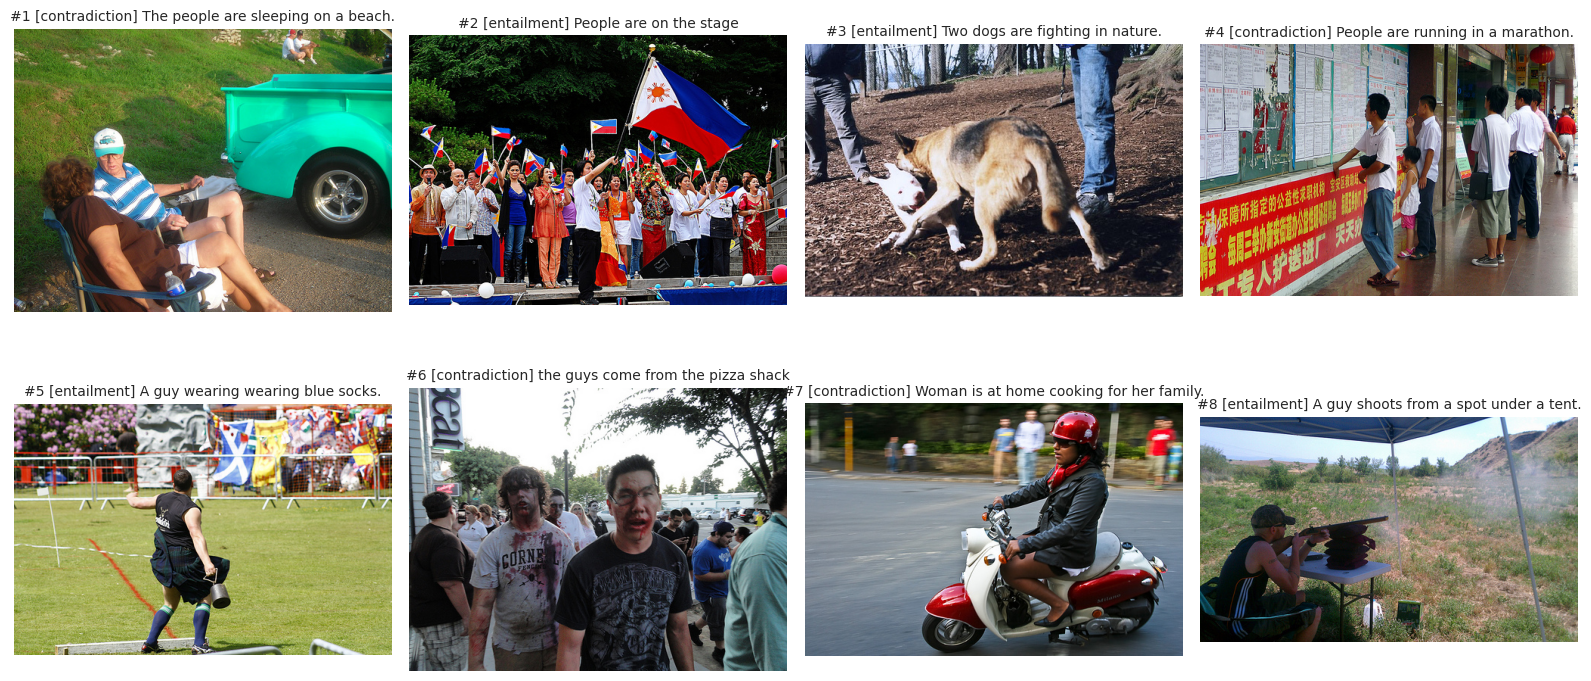

In [7]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import textwrap


# ---------- Grid view (R x C) ----------
def show_grid(df, R=2, C=3, seed=42, wrap=40):
    rng = np.random.default_rng(seed)
    idxs = rng.choice(len(df), size=R*C, replace=False)
    fig, axes = plt.subplots(R, C, figsize=(4*C, 4*R))
    axes = axes.ravel()

    for num, (ax, i) in enumerate(zip(axes, idxs), start=1):
        row = df.iloc[i]
        try:
            img = Image.open(row["path"]).convert("RGB")
            ax.imshow(img)
        except Exception as e:
            ax.text(0.5, 0.5, f"Error:\n{e}", ha="center", va="center")
        ax.axis("off")

        label = "entailment" if row["y"] == 1 else "contradiction"
        hypo_wrapped = "\n".join(textwrap.wrap(row["hypo"], width=wrap))
        ax.set_title(f"#{num} [{label}] {hypo_wrapped}", fontsize=10)
    plt.tight_layout()
    plt.show()
    
show_grid(df, R=2, C=4, seed=42)  


### Observation
- The dataset appears to be well aligned
- however some images might create a confusion to the model such as Image #4 is labeled contradiction for the hypothesis “People are running in a marathon.” which is correct. However, in a single 2D frame the linear alignment of people, forward-facing orientation, and street context can mimic “running posture” cues, even though everyone is actually standing and reading. A vision model that leans on global layout heuristics (row of people + sidewalk + banners) may overgeneralize and predict entailment on similar scenes, especially when verbs imply motion but no motion cues exist in still images. In normal CLS-level fusion this might get confused, as it will treat the overall sentence and image as single global summaries, whereas token level cross attention might be better. 
- In image number 4 same confusion might arise with nomal fusion of the model, though the image and label are algned correctly however if there is a image in the distribution that the people are sitting in the beach chair, then the model might get confused with picture like this as the sitting posture matches with how people sit in the beach.

### Understanding Label distribution, text length

We tried to understand both the label distribution and the hypothesis length in the dataset. The label distribution plot shows how many samples belong to each class: 0 for contradiction and 1 for entailment. This gives an early indication of whether the dataset is balanced or skewed, which is important for training a fair model. Next, we examined the length of hypotheses by counting the number of tokens in each sentence and plotting a histogram. This analysis helps decide the appropriate maximum sequence length for BERT so that most sentences are captured without unnecessary padding. Finally, we sampled a few random examples to manually check the alignment between image paths, hypotheses, and labels, ensuring that the data is correctly structured for downstream modeling.

Class counts:
 y
1    19619
0    19510
Name: count, dtype: int64


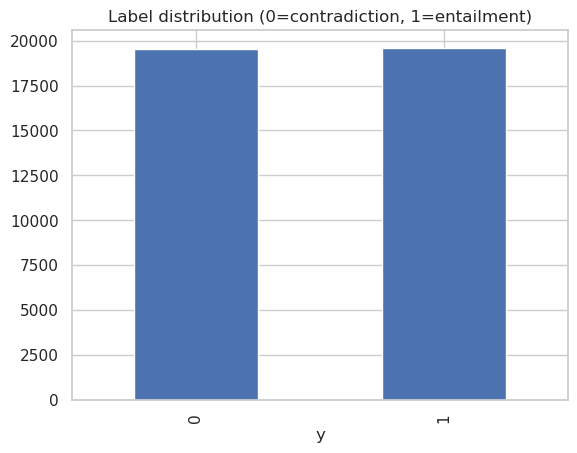

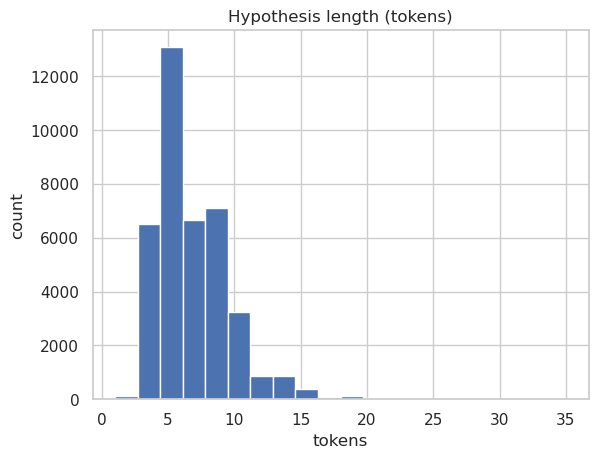

,path,hypo,y
38567,A2_Images/448590900.jpg,the dog is playing in the snow,0
6231,A2_Images/195962790.jpg,A lady is sitting outside.,1
34954,A2_Images/3735084476.jpg,A old man is working the soil of a farm.,1


In [8]:
# === 2. EDA ===
print("Class counts:\n", df["y"].value_counts())
df["len_hypo"] = df["hypo"].str.split().apply(len)

plt.figure(); df["y"].value_counts().sort_index().plot(kind="bar")
plt.title("Label distribution (0=contradiction, 1=entailment)"); plt.show()

plt.figure(); plt.hist(df["len_hypo"], bins=20)
plt.title("Hypothesis length (tokens)"); plt.xlabel("tokens"); plt.ylabel("count"); plt.show()

# Show a few samples
df.sample(3, random_state=SEED)[["path","hypo","y"]]


### Observation
- The dataset contains 39,129 usable samples with no missing images, which confirms a clean alignment between hypotheses and visual data.
- The label distribution is almost perfectly balanced: entailment (y=1) and contradiction (y=0) are present in nearly equal proportions. This balance reduces the risk of bias toward one class during training.
- Hypothesis lengths are generally short, with most sentences between 4–12 tokens, and very few exceeding 20 tokens. This validates that a maximum sequence length of 32–35 tokens for BERT is more than sufficient, minimizing unnecessary padding.

### Checking if the image count match the hypothesis

In [9]:
# Count how many hypotheses per image_id
counts = df["image_id"].value_counts()

# Show a few images with multiple hypotheses
multi = df[df["image_id"].isin(counts[counts > 1].index)]

# Look at first few
multi.head(10)[["image_id","hypo","y"]]

,image_id,hypo,y
0,4564320256,The old woman and a girl are bored.,1
1,4564320256,Two old men robbing a convenience store.,0
2,4564320256,A man implies that he is very strong.,0
4,369186134,Dogs are out in the snow,1
5,369186134,There are some dogs.,1
6,3691642887,A kid helps a man fix a door.,1
7,3691642887,The man and boy are at the game waiting for a ...,0
8,3861381128,People are celebrating with music and costumes.,1
9,3861381128,A village celebrates a holiday in the street.,1
10,3504275465,The dog jumped over the small river and landed...,0


### Observation 
- There are multiple hypothesis for a single image
- This is normal, as for a single image there will be hypothesis that is entailment or some will be contradiction
- Since this is the case, we should to stratification while splitting the data based on the image_id as if we are doing random spliting, it might happen that same image is on the training and test set which will introduce data leakage. Stratifying by image_id ensures that all hypotheses associated with a particular image stay within the same split while still preserving the overall class distribution.

### Text length distribution
In this block we are zooming in the text to see how it is distributed

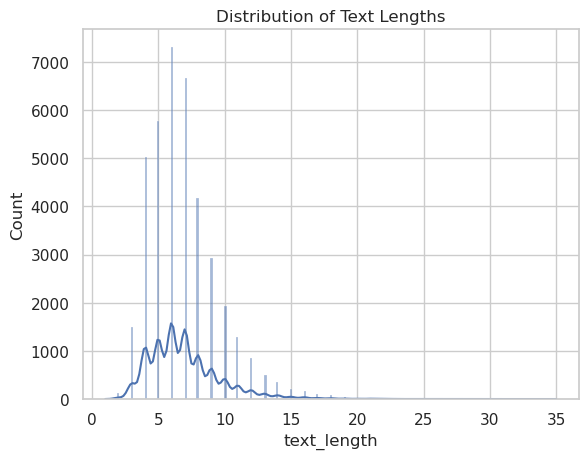

count    39129.000000
mean         6.935291
std          2.732952
min          1.000000
25%          5.000000
50%          6.000000
75%          8.000000
max         35.000000
Name: text_length, dtype: float64


In [10]:
temp_df = pd.DataFrame()

# Calculate the length of text for each sample in words
temp_df['text_length'] = df['hypo'].apply(lambda x: len(x.split()))

# Plot the distribution of text lengths with a kernel density estimate
sns.histplot(temp_df['text_length'], kde=True)
plt.title("Distribution of Text Lengths")
plt.show()

# Display descriptive statistics for text lengths to check for outliers
print(temp_df['text_length'].describe())

## Observations
- The dataset has 39,129 hypotheses in total.
- The average length of hypotheses is about 6.9 words, with a standard deviation of 2.7, meaning most sentences are short and don’t vary too much in length.
- The minimum length is 1 word and the maximum is 35 words.
- 50% of the hypotheses are 6 words or fewer, and 75% are 8 words or fewer.
- The KDE plot shows a strong peak between 5–8 words, confirming that the majority of hypotheses are concise.
- Only a very small number of samples approach the upper bound of 30–35 words, which means setting a BERT max sequence length of 32–35 tokens is safe and will capture all hypotheses without much truncation.

### Sanity Check of the text
We want to catch textual artefacts (hyperlinks, emojis, email/user handles, weird punctuation, shouting/all-caps, non-ASCII symbols) which can distract the model or break tokenization. So we scan each hypothesis, sets per-row flags, summarizes prevalence, and print the outliers.

In [11]:
import re
import pandas as pd

# --- regex helpers ---
url_re     = re.compile(r'https?://\S+|www\.\S+', re.IGNORECASE)
email_re   = re.compile(r'\b[a-z0-9._%+-]+@[a-z0-9.-]+\.[a-z]{2,}\b', re.IGNORECASE)
user_re    = re.compile(r'(^|[\s:])[@#][A-Za-z0-9_]+')   # @handle or #hashtag
emoji_re   = re.compile(
    r'['
    r'\U0001F300-\U0001F6FF'  # symbols & pictographs
    r'\U0001F700-\U0001F77F'
    r'\U0001F780-\U0001F7FF'
    r'\U0001F800-\U0001F9FF'
    r'\U0001FA00-\U0001FAFF'
    r'\U00002600-\U000026FF'  # misc symbols
    r'\U00002700-\U000027BF'
    r']'
)
nonascii_re = re.compile(r'[^\x00-\x7F]')               # any non-ASCII char
multi_punct = re.compile(r'[!?]{2,}|(\.\s*){3,}')       # !!, ???, ... (3+ dots)
repeat_char = re.compile(r'(.)\1{3,}', re.IGNORECASE)   # aaaa, !!!!, etc.

def has_url(s):     return bool(url_re.search(s))
def has_email(s):   return bool(email_re.search(s))
def has_user(s):    return bool(user_re.search(s))
def has_emoji(s):   return bool(emoji_re.search(s))
def has_nonascii(s):return bool(nonascii_re.search(s))
def has_multi_punct(s): return bool(multi_punct.search(s))
def has_repeat_char(s): return bool(repeat_char.search(s))
def has_allcaps_token(s):
    toks = re.findall(r"\b[A-Za-z]{2,}\b", s)
    return any(t.isupper() for t in toks)

# --- add flags to df ---
col = "hypo"
df["has_url"]        = df[col].str.contains(url_re)
df["has_email"]      = df[col].str.contains(email_re)
df["has_user"]       = df[col].str.contains(user_re)
df["has_emoji"]      = df[col].str.contains(emoji_re)
df["has_nonascii"]   = df[col].str.contains(nonascii_re)
df["has_multi_punct"]= df[col].str.contains(multi_punct)
df["has_repeat_char"]= df[col].str.contains(repeat_char)
df["has_allcaps"]    = df[col].apply(has_allcaps_token)

# --- prevalence summary ---
flags = ["has_url","has_email","has_user","has_emoji","has_nonascii",
         "has_multi_punct","has_repeat_char","has_allcaps"]

summary = (df[flags].mean().sort_values(ascending=False) * 100).round(2)
print("Noise feature prevalence (% of rows):\n", summary.to_string())

# --- peek at a few examples per issue ---
def show_examples(flag, k=5):
    ex = df.loc[df[flag], [col]].head(k)
    print(f"\nExamples for {flag} ({len(ex)} shown):")
    for i, t in enumerate(ex[col].tolist(), 1):
        print(f"{i:>2}. {t}")

for f in flags:
    if df[f].any():
        show_examples(f, k=3)


/tmp/ipykernel_10238/3125258016.py:38: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df["has_user"]       = df[col].str.contains(user_re)
/tmp/ipykernel_10238/3125258016.py:41: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df["has_multi_punct"]= df[col].str.contains(multi_punct)
/tmp/ipykernel_10238/3125258016.py:42: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df["has_repeat_char"]= df[col].str.contains(repeat_char)


Noise feature prevalence (% of rows):
 has_allcaps        0.44
has_url            0.00
has_multi_punct    0.00
has_email          0.00
has_emoji          0.00
has_user           0.00
has_nonascii       0.00
has_repeat_char    0.00

Examples for has_url (1 shown):
 1. http://fresnosmilemakeovers.com/

Examples for has_multi_punct (1 shown):
 1. And slar and slue...

Examples for has_allcaps (3 shown):
 1. A lifeguard is giving CPR to a man he just dragged out of the ocean.
 2. THERE ARE TOYS BEING PLAYED WITH BY A CHILD IN PAJAMAS
 3. A man and a child watched TV.


### Observation
- URLs, emails, emojis, and user handles were found in 0% of rows, confirming there are no hyperlinks or social media artifacts.
- Only 0.44% of samples contain ALL-CAPS words, such as “CPR” or entire sentences in uppercase. These are rare and not harmful, as they often represent acronyms or emphasis rather than noise.
- Minor punctuation anomalies (like ellipses “…”) appeared in isolated cases.

### Remedy
- Though the dataset appears overall very clean, we can normalize ALL-CAPS words to lowercase (except known acronyms like “CPR”,"TV") and trim extra punctuation.

### Checking for negation

This block extends the EDA by looking at linguistic features of the hypotheses, especially focusing on negations. The motivation here is that negation words (“not”, “never”, “no”, etc.) often flip the meaning of a sentence and are highly relevant in entailment/contradiction tasks. By explicitly checking their prevalence, we get an idea of how much the dataset challenges the model to reason about negation.

          len_words     len_chars
count  39129.000000  39129.000000
mean       6.935291     34.865522
std        2.732952     14.044893
min        1.000000      1.000000
25%        5.000000     25.000000
50%        6.000000     32.000000
75%        8.000000     41.000000
max       35.000000    204.000000


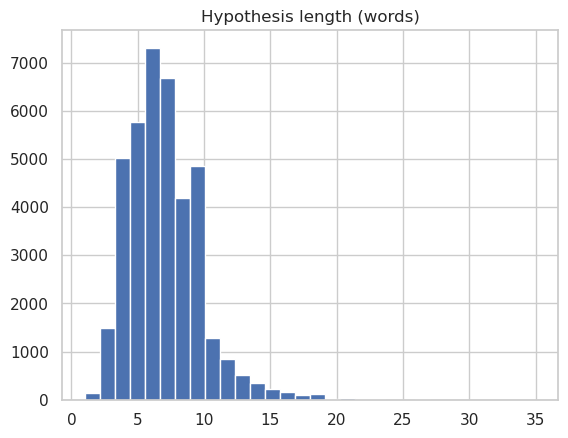

Negation prevalence: 0.02680876076567252


In [12]:
neg_words = {"no","not","none","never","without","nothing","nobody","isn't","aren't","wasn't","weren't","don't","doesn't","didn't","can't","cannot","won't","wouldn't","shouldn't"}

df["len_words"] = df["hypo"].str.split().str.len()
df["len_chars"] = df["hypo"].str.len()
df["has_neg"]   = df["hypo"].str.lower().apply(lambda s: any(w in s.split() for w in neg_words))

print(df[["len_words","len_chars","has_neg"]].describe())
plt.figure(); plt.hist(df["len_words"], bins=30); plt.title("Hypothesis length (words)"); plt.show()
print("Negation prevalence:", df["has_neg"].mean())


## Observation 
- In terms of characters, the average length is ~35 characters, with some longer outliers up to 204 characters.
- The histogram confirms a strong concentration of hypotheses around short lengths, with very few extending beyond 15 words.
- Negation prevalence is about 2.7% of all hypotheses. This indicates that explicit negation words are relatively rare in the dataset, but they are crucial cases since they often drive contradiction labels.

### Checking duplicate data to prevent leak

In [13]:
dup_exact = df.duplicated(subset=["image_id","hypo","y"])
print("Exact duplicates:", dup_exact.sum())
df[dup_exact].head()


Exact duplicates: 7


,image_id,path,hypo,y,len_hypo,has_url,has_email,has_user,has_emoji,has_nonascii,has_multi_punct,has_repeat_char,has_allcaps,len_words,len_chars,has_neg
1399,3389458786,A2_Images/3389458786.jpg,The boy and girl are wearing sweatpants.,0,7,False,False,False,False,False,False,False,False,7,40,False
3485,4970780316,A2_Images/4970780316.jpg,A woman by a fence.,1,5,False,False,False,False,False,False,False,False,5,19,False
8851,3128965175,A2_Images/3128965175.jpg,A girl plays checkers.,1,4,False,False,False,False,False,False,False,False,4,22,False
10931,4171253174,A2_Images/4171253174.jpg,The woman is wearing clothes.,1,5,False,False,False,False,False,False,False,False,5,29,False
11446,2813005964,A2_Images/2813005964.jpg,A girl is eating.,1,4,False,False,False,False,False,False,False,False,4,17,False


## Observation
- In the dataset there are total 7 duplicate value
- However this duplicate data may induce data leakage which should be taken care of

## Remedy
- We should remove exact duplicates using drop_duplicates on (image_id, hypo, y).
- We should also check for label conflicts (same (image_id, hypothesis) with different labels) and resolve them by majority vote, while dropping ties to avoid ambiguity.

## Data Cleaning

### Cleaning duplicate data and noise
This cell audits and cleans duplicates specific to visual–textual entailment. Because each image can legitimately appear with many hypotheses, we first quantify harmless image reuse, then isolate true issues: (a) exact duplicate rows where the same (image_id, hypothesis, label) is repeated, and (b) label conflicts where the same (image_id, hypothesis) has both labels (0 and 1). Exact duplicates inflate sample weight and risk leakage across splits; conflicts indicate annotation inconsistency. The cleaning policy removes exact duplicates, then resolves conflicts by majority vote per (image_id, hypothesis) and drops ties to stay conservative. Finally, assertions verify paths exist, labels are valid, and hypotheses are non-empty (while allowing multiple hypotheses per image, which is normal in VE). The result is a deduplicated, self-consistent dataset that reduces leakage risk and training bias. Afterwards we applied a light text cleaner that strips rare URLs/emails, collapses excessive punctuation, and normalizes non-acronym ALL-CAPS tokens (keeping acronyms like CPR/TV/USA). The function returns a cleaned DataFrame (df_clean) plus a small report summarizing rows before/after, duplicates removed, conflicts handled, and final class distribution—making the preprocessing transparent, leakage-resistant, and ready for group-stratified splitting and training.

In [14]:
import re
import pandas as pd
import os

# ---------- light text cleaner ----------
def clean_hypothesis(text):
    if not isinstance(text, str):
        return text
    # remove URLs & emails
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'\b[a-z0-9._%+-]+@[a-z0-9.-]+\.[a-z]{2,}\b', '', text)
    # collapse excessive punctuation
    text = re.sub(r'([!?]){2,}', r'\1', text)
    text = re.sub(r'\.{3,}', '.', text)
    # normalize ALL-CAPS except known acronyms
    acronyms = {"CPR","USA","TV","NASA"}
    toks = []
    for tok in text.split():
        toks.append(tok if not (tok.isupper() and tok not in acronyms) else tok.lower())
    text = " ".join(toks)
    # normalize spaces
    return re.sub(r'\s+', ' ', text).strip()

# ---------- full dataset cleaner (your dedup + conflicts + text) ----------
def clean_dataset(df):
    df = df.copy()
    report = {}

    # A) measure before
    report["rows_before"] = len(df)

    # B) harmless reuse count (FYI)
    report["image_reuse_rows"] = int(df["image_id"].duplicated().sum())

    # C) exact duplicates
    dup_exact_mask = df.duplicated(subset=["image_id","hypo","y"])
    report["dup_exact_found"] = int(dup_exact_mask.sum())
    if report["dup_exact_found"] > 0:
        df = df.drop_duplicates(subset=["image_id","hypo","y"]).copy()

    # D) label conflicts (same image_id + hypo, different y)
    conflicts = (
        df.groupby(["image_id","hypo"])["y"]
          .nunique()
          .reset_index(name="n_labels")
          .query("n_labels > 1")
    )
    report["label_conflicts_found"] = int(len(conflicts))

    if len(conflicts):
        counts = (
            df.groupby(["image_id","hypo","y"]).size()
              .reset_index(name="cnt")
        )
        winners = counts.loc[counts.groupby(["image_id","hypo"])["cnt"].idxmax()]
        # detect ties
        tie_mask = (
            counts.merge(
                winners[["image_id","hypo","cnt"]],
                on=["image_id","hypo","cnt"],
                how="right"
            ).groupby(["image_id","hypo"]).size().gt(1)
        )
        ties = tie_mask[tie_mask].index if hasattr(tie_mask, "index") else []
        report["label_ties_dropped_pairs"] = int(len(ties)) if len(conflicts) else 0

        keep_pairs = set(zip(winners["image_id"], winners["hypo"], winners["y"]))
        df = df[[ (iid, h, y) in keep_pairs for iid, h, y in zip(df.image_id, df.hypo, df.y) ]].copy()

    # E) assertions after structure clean
    assert (df["path"].apply(os.path.exists)).all(), "Some image paths are missing."
    assert df["y"].isin([0,1]).all(), "Found invalid labels."
    assert df["hypo"].astype(str).str.strip().ne("").all(), "Found empty hypotheses."

    # F) text cleaning (light)
    df["hypo"] = df["hypo"].apply(clean_hypothesis)

    # G) measure after
    report["rows_after"] = len(df)
    report["class_dist_after"] = df["y"].value_counts(normalize=True).round(3).to_dict()

    print(
        "Clean OK:",
        f"rows {report['rows_before']} -> {report['rows_after']};",
        f"exact dups removed={report['dup_exact_found']};",
        f"conflicts={report['label_conflicts_found']};",
        f"ties_dropped={report.get('label_ties_dropped_pairs', 0)};",
        f"class_dist={report['class_dist_after']}"
    )
    return df, report

# ---------- usage ----------
df_clean, clean_report = clean_dataset(df)






Clean OK: rows 39129 -> 39122; exact dups removed=7; conflicts=0; ties_dropped=0; class_dist={1: 0.501, 0: 0.499}


### Image quality check

This block performs an image-level EDA to check the quality and distribution of the visual data. Instead of just relying on filenames, it opens each image from a random sample of 3000, extracts key metadata, and computes simple statistics related to brightness, contrast, and sharpness. The aim is to catch problems such as corrupt images, extreme aspect ratios, or very dark/blurry samples that could affect model training.

Corrupt images in sample: 0


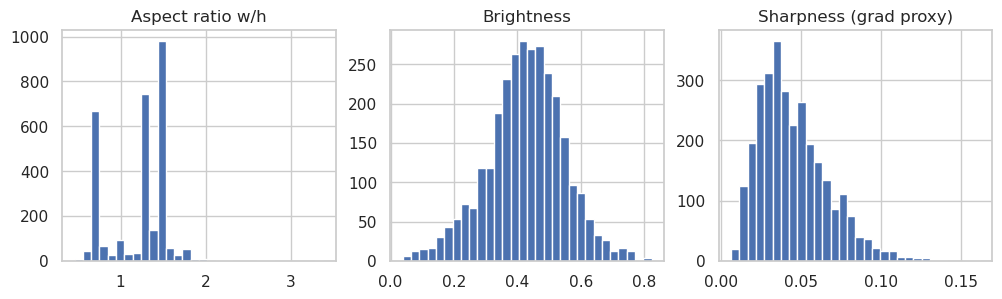

In [15]:
from PIL import Image
import numpy as np, os, pandas as pd, matplotlib.pyplot as plt

def image_meta(path):
    try:
        with Image.open(path) as im:
            w, h = im.size
            gray = im.convert("L")
            arr  = np.asarray(gray, dtype=np.float32) / 255.0
            bright   = float(arr.mean())             # 0..1
            contrast = float(arr.std())              # 0..~0.3
            # simple sharpness proxy: mean gradient magnitude (no OpenCV needed)
            gx = np.abs(np.diff(arr, axis=1)).mean()
            gy = np.abs(np.diff(arr, axis=0)).mean()
            sharp = float((gx + gy) / 2)
            size_bytes = os.path.getsize(path)
            ext = os.path.splitext(path)[1].lower()
            return w, h, (w/h), bright, contrast, sharp, size_bytes, ext, 1
    except Exception:
        return None, None, None, None, None, None, None, None, 0  # corrupt

# sample or full set
sample_paths = df["path"].sample(min(3000, len(df_clean)), random_state=42).tolist()
meta = [image_meta(p) for p in sample_paths]
meta_df = pd.DataFrame(meta, columns=["w","h","aspect","brightness","contrast","sharp","bytes","ext","ok"])

print("Corrupt images in sample:", (meta_df["ok"]==0).sum())
fig, axes = plt.subplots(1,3, figsize=(12,3))
axes[0].hist(meta_df["aspect"].dropna(), bins=30); axes[0].set_title("Aspect ratio w/h")
axes[1].hist(meta_df["brightness"].dropna(), bins=30); axes[1].set_title("Brightness")
axes[2].hist(meta_df["sharp"].dropna(), bins=30); axes[2].set_title("Sharpness (grad proxy)")
plt.show()

## Observations 
- Corrupt images: None were detected in the 3,000-image sample, confirming the dataset is intact.
- Aspect ratio: The distribution shows a few dominant peaks, mostly around 1.0–1.7. This suggests that the images are not all uniform in shape, but most fall into standard photographic proportions (close to square or landscape). Extreme aspect ratios (>2.5) are rare, so resizing to a fixed input size (e.g., 224×224 for EfficientNet) is safe.
- Brightness: The histogram is approximately bell-shaped and centered around 0.4–0.5, meaning most images have mid-level brightness. Very dark (<0.2) or very bright (>0.7) samples are uncommon, so overall exposure quality looks good.
- Sharpness: The majority of images cluster around 0.02–0.06 (gradient proxy), showing they contain enough edges and detail. A small tail toward lower sharpness values indicates a few blurry images, but not in significant numbers.

## Data Splitting
We are doing stratified data splitting to make sure the dataset is divided fairly and without any data leakage. Since multiple samples can come from the same image (identified by "image_id"), a normal random split could accidentally place parts of the same image into both training and testing sets, which would make the model’s performance look unrealistically good. To avoid this, we group the data by "image_id" so that all samples from the same image stay together in a single split. At the same time, we use stratification based on the label "y" to maintain a similar class balance across train, validation, and test sets. We perform the splitting in two stages, first to separate out the test set (15%) and then to divide the remaining data into training and validation sets so that the test data remains completely unseen until final evaluation. Finally, we run summary checks to confirm that the splits are balanced and that no image appears in more than one split.


In [16]:
# ============================================
# Group-stratified Split by image_id + post-split check
# ============================================
from sklearn.model_selection import StratifiedGroupKFold
import numpy as np

# prepare arrays
X = df_clean.index
y = df_clean["y"]
groups = df_clean["image_id"]

# First split: train+val vs test (15% test)
sgkf = StratifiedGroupKFold(n_splits=10, shuffle=True, random_state=SEED)
trainval_idx, test_idx = next(sgkf.split(X, y, groups))

trainval_df = df.iloc[trainval_idx].copy()
test_df     = df.iloc[test_idx].copy()

# Second split: train vs val (15% of trainval for validation)
y_tv = trainval_df["y"]
g_tv = trainval_df["image_id"]
sgkf2 = StratifiedGroupKFold(n_splits=10, shuffle=True, random_state=SEED)
train_idx, val_idx = next(sgkf2.split(trainval_df.index, y_tv, g_tv))

train_df = trainval_df.iloc[train_idx].copy()
val_df   = trainval_df.iloc[val_idx].copy()

# ensure len_words exists
for frame in (train_df, val_df, test_df):
    if "len_words" not in frame.columns:
        frame["len_words"] = frame["hypo"].str.split().str.len()

# summary check
for name, d in [("train", train_df), ("val", val_df), ("test", test_df)]:
    mu = float(d["len_words"].mean())
    sigma = float(d["len_words"].std())
    print(
        name,
        "size=", len(d),
        "label dist=", d["y"].value_counts(normalize=True).round(3).to_dict(),
        "len_words μ±σ=", (round(mu, 2), round(sigma, 2)),
        "unique images=", d["image_id"].nunique()
    )



train size= 31674 label dist= {1: 0.501, 0: 0.499} len_words μ±σ= (6.93, 2.73) unique images= 16478
val size= 3482 label dist= {1: 0.503, 0: 0.497} len_words μ±σ= (6.95, 2.75) unique images= 1846
test size= 3966 label dist= {1: 0.505, 0: 0.495} len_words μ±σ= (6.95, 2.75) unique images= 2889


In [17]:
import tensorflow as tf
import keras, keras_hub
from keras import layers

IMG_SIZE = (224, 224)
SEQ_LEN  = 32
PRESET   = "bert_small_en_uncased"  # pick a preset you have

# image loader / augment (pure keras layers)
def decode_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    img.set_shape((*IMG_SIZE, 3))
    return img

augment = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomContrast(0.1),
], name="img_aug")

# --- Instantiate the KerasHub preprocessor ONCE (outside the model) ---
try:
    preproc = keras_hub.models.BertPreprocessor.from_preset(PRESET, sequence_length=SEQ_LEN)
except AttributeError:
    # fallback for versions exposing a generic classifier preprocessor
    preproc = keras_hub.models.TextClassifierPreprocessor.from_preset(PRESET, sequence_length=SEQ_LEN)

# Make sure you have these in scope:
# preproc = keras_hub.models.BertPreprocessor.from_preset(PRESET, sequence_length=SEQ_LEN)
# or the TextClassifierPreprocessor fallback, as you used before.

def _bert_pack(hypo_str):
    """
    Robustly run KerasHub BERT preprocessor in tf.data:
    - Expand dims to [1] so outputs are [1, SEQ_LEN]
    - Then squeeze back to [SEQ_LEN]
    - Normalize key names across versions
    """
    h = tf.expand_dims(hypo_str, 0)         # [1]
    out = preproc(h)                         # dict with [1, SEQ_LEN] tensors

    # key normalization (some versions use 'segment_ids', others 'token_type_ids')
    seg_key = "segment_ids"
    if seg_key not in out:
        seg_key = "token_type_ids" if "token_type_ids" in out else None

    token_ids    = tf.squeeze(out["token_ids"],    axis=0)   # (SEQ_LEN,)
    padding_mask = tf.squeeze(out["padding_mask"], axis=0)   # (SEQ_LEN,)
    if seg_key is not None:
        segment_ids = tf.squeeze(out[seg_key], axis=0)       # (SEQ_LEN,)
    else:
        segment_ids = tf.zeros_like(token_ids)               # (SEQ_LEN,)

    # set static shapes for tf.function tracing
    token_ids.set_shape((SEQ_LEN,))
    segment_ids.set_shape((SEQ_LEN,))
    padding_mask.set_shape((SEQ_LEN,))

    # (types are usually int32/int32/bool already; enforce if needed)
    token_ids    = tf.cast(token_ids, tf.int32)
    segment_ids  = tf.cast(segment_ids, tf.int32)
    padding_mask = tf.cast(padding_mask, tf.bool)

    return token_ids, segment_ids, padding_mask


def make_ds_bert(frame, training: bool, batch=32):
    ds = tf.data.Dataset.from_tensor_slices(
        (frame["path"].values, frame["hypo"].values, frame["y"].values)
    )
    if training:
        ds = ds.shuffle(len(frame), seed=42)

    def _map(p, h, y):
        img = decode_image(p)
        if training:
            img = augment(img)
        tok, seg, mask = _bert_pack(h)
        features = {
            "image": img,
            "token_ids": tok,
            "segment_ids": seg,
            "padding_mask": mask,
        }
        return features, tf.cast(y, tf.float32)

    return ds.map(_map, num_parallel_calls=tf.data.AUTOTUNE)\
             .batch(batch)\
             .prefetch(tf.data.AUTOTUNE)


I0000 00:00:1759796277.959298   10238 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13760 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:1e.0, compute capability: 7.5


100%|██████████| 455/455 [00:00<00:00, 977kB/s]


100%|██████████| 761/761 [00:00<00:00, 1.48MB/s]


100%|██████████| 226k/226k [00:01<00:00, 197kB/s]


## Setting up Goal 

Previous work on standard entailment datasets such as SNLI and MNLI shows that human annotators agree on about 90% of examples, which is widely considered the human-level ceiling. Accuracy is therefore chosen as the evaluation metric, since the dataset is relatively balanced across classes and accuracy remains the dominant measure in the NLI literature, making results interpretable and directly comparable to existing benchmarks. In this project, the baseline model combines BERT for text and EfficientNet for images, with their feature representations concatenated before classification. While both backbones are powerful, simple concatenation does not allow meaningful interaction between modalities, so the baseline is expected to achieve moderate accuracy in the range of 70–75%. The final model introduces cross-attention to enable direct alignment between text tokens and image regions, which should provide a clear performance boost, pushing accuracy closer to 80–85% and narrowing the gap toward human-level performance.

## Baseline Model

### Stage-1 Keeping both backbones frozen
In the stage 1 the model is trained with frozen and then in stage 2 we are unfreezing some layer

In [18]:
def build_concat_keras_hub_bert(img_shape=(224,224,3), preset=PRESET, seq_len=SEQ_LEN):
    # Image branch (frozen EfficientNet)
    img_in   = layers.Input(shape=img_shape, name="image")
    img_base = keras.applications.EfficientNetB0(include_top=False, input_shape=img_shape, weights="imagenet")
    img_base.trainable = False
    xi = img_base(img_in, training=False)
    xi = layers.GlobalAveragePooling2D(name="img_gap")(xi)

    # BERT numeric inputs (from dataset)
    token_ids_in    = layers.Input(shape=(seq_len,), dtype="int32",  name="token_ids")
    segment_ids_in  = layers.Input(shape=(seq_len,), dtype="int32",  name="segment_ids")
    padding_mask_in = layers.Input(shape=(seq_len,), dtype="bool",   name="padding_mask")

    bert_in = {
        "token_ids": token_ids_in,
        "segment_ids": segment_ids_in,
        "padding_mask": padding_mask_in,
    }

    bert = keras_hub.models.BertBackbone.from_preset(preset)
    bert.trainable = False  # start frozen
    bert_out = bert(bert_in)                       # dict
    t_pooled = bert_out["pooled_output"]          # [CLS]

    # Concat fusion + head
    z = layers.Concatenate()([xi, t_pooled])
    z = layers.Dense(256, activation="relu")(z)
    z = layers.BatchNormalization()(z)
    z = layers.Dropout(0.4)(z)
    out = layers.Dense(1, activation="sigmoid")(z)

    return keras.Model(
        inputs={"image": img_in, "token_ids": token_ids_in, "segment_ids": segment_ids_in, "padding_mask": padding_mask_in},
        outputs=out,
        name="baseline_concat_keras_hub_bert_numeric",
    )

model = build_concat_keras_hub_bert()
model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss="binary_crossentropy",
              metrics=[keras.metrics.BinaryAccuracy(name="acc")])
model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


100%|██████████| 110M/110M [00:09<00:00, 12.1MB/s] 


Model: "baseline_concat_keras_hub_bert_numeric"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb0      │ (None, 7, 7,      │  4,049,571 │ image[0][0]       │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ padding_mask        │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ segment_ids         │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_ids           │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ img_gap             │ (None, 1280)      │          0 │ efficientnetb0[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_backbone       │ [(None, 512),     │ 28,763,648 │ padding_mask[0][… │
│ (BertBackbone)      │ (None, 32, 512)]  │            │ segment_ids[0][0… │
│                     │                   │            │ token_ids[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1792)      │          0 │ img_gap[0][0],    │
│ (Concatenate)       │                   │            │ bert_backbone[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    459,008 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256)       │      1,024 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │        257 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 33,273,508 (126.93 MB)

 Trainable params: 459,777 (1.75 MB)

 Non-trainable params: 32,813,731 (125.17 MB)

In [19]:

# hist = model.fit(train_ds, validation_data=val_ds, epochs=2, callbacks=cbs, verbose=1)

# # Keep curves in notebook (rubric requires)
# plt.figure(); plt.plot(hist.history["loss"]); plt.plot(hist.history["val_loss"])
# plt.title("Loss"); plt.legend(["train","val"]); plt.show()
# plt.figure(); plt.plot(hist.history["acc"]); plt.plot(hist.history["val_acc"])
# plt.title("Accuracy"); plt.legend(["train","val"]); plt.show()


### Stage 2 , unfreezing some of the layer

In [20]:
# ------- Utilities to unfreeze selectively -------
import keras
from keras import layers

def unfreeze_efficientnet_top(model, pct=0.3, freeze_bn=True):
    """Unfreeze top pct of EfficientNet layers in-place."""
    eff = next((l for l in model.layers if isinstance(l, keras.Model) and "efficientnet" in l.name.lower()), None)
    if eff is None:
        print("EfficientNet backbone not found."); return
    n = len(eff.layers)
    cut = int(n * (1 - pct))
    for i, lyr in enumerate(eff.layers):
        lyr.trainable = (i >= cut)
        if freeze_bn and isinstance(lyr, layers.BatchNormalization):
            lyr.trainable = False
    print(f"EfficientNet: set trainable on top {pct*100:.0f}% (~{n-cut}/{n} layers). BN frozen={freeze_bn}")


def unfreeze_bert_last_n_smart(model, n=2):
    """Unfreeze the last n transformer blocks of a KerasHub BertBackbone inside `model`.
       Tries multiple attribute layouts; falls back to unfreezing the last few trainable sublayers.
    """
    # find the BertBackbone submodel
    bert = next((l for l in model.layers if isinstance(l, keras.Model) and "bert" in l.name.lower()), None)
    if bert is None:
        print("BERT backbone not found."); 
        return False

    # 1) KerasHub sometimes exposes `transformer_layers`
    if hasattr(bert, "transformer_layers") and bert.transformer_layers:
        blocks = list(bert.transformer_layers)
        for i, blk in enumerate(blocks):
            blk.trainable = (i >= len(blocks) - n)
        print(f"BERT: set trainable on last {n}/{len(blocks)} transformer_layers")
        return True

    # 2) Older/newer shapes: encoder.layers
    enc = getattr(bert, "encoder", None)
    if enc is not None and hasattr(enc, "layers") and enc.layers:
        blocks = list(enc.layers)
        for i, blk in enumerate(blocks):
            blk.trainable = (i >= len(blocks) - n)
        print(f"BERT: set trainable on last {n}/{len(blocks)} encoder layers")
        return True

    # 3) Name-based grouping (catch-all)
    #    Find top-level blocks whose names look like encoder/transformer blocks.
    block_candidates = []
    for l in bert.layers:
        if re.search(r"(transformer|encoder).*block", l.name):
            block_candidates.append(l)
    if block_candidates:
        for i, blk in enumerate(block_candidates):
            blk.trainable = (i >= len(block_candidates) - n)
        print(f"BERT: set trainable on last {n}/{len(block_candidates)} name-detected blocks")
        return True

    # 4) Final fallback: unfreeze the last K trainable sublayers (coarse but effective)
    trainable_sublayers = [l for l in bert.submodules if hasattr(l, "trainable_weights") and l.trainable_weights]
    if trainable_sublayers:
        K = max(10, 4*n)  # heuristic
        for l in trainable_sublayers[:-K]:
            l.trainable = False
        for l in trainable_sublayers[-K:]:
            l.trainable = True
        print(f"BERT: block list not found; unfroze last {K} trainable sublayers (fallback).")
        return True

    print("BERT encoder blocks still not accessible; left BERT frozen.")
    return False

def recompile_for_finetune(model, lr=1e-5):
    model.compile(optimizer=keras.optimizers.Adam(lr),
                  loss="binary_crossentropy",
                  metrics=[keras.metrics.BinaryAccuracy(name="acc")])


In [21]:
train_ds = make_ds_bert(train_df, training=True,  batch=32)
val_ds   = make_ds_bert(val_df,   training=False, batch=32)

cbs = [
    keras.callbacks.ModelCheckpoint("artifacts/best_bert_concat.keras", monitor="val_acc", mode="max", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_acc", mode="max", patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_acc", mode="max", factor=0.5, patience=2),
]

Epoch 1/100


2025-10-06 18:41:13.761811: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT64 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
I0000 00:00:1759776085.232173   25778 service.cc:152] XLA service 0x7fc4a000c640 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759776085.232197   25778 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-10-06 18:41:25.703518: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1759776087.828665   25778 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/990 ━━━━━━━━━━━━━━━━━━━━ 7:56:09 29s/step - acc: 0.4688 - loss: 0.9342

I0000 00:00:1759776102.144138   25778 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


990/990 ━━━━━━━━━━━━━━━━━━━━ 472s 448ms/step - acc: 0.6086 - loss: 0.7025 - val_acc: 0.6017 - val_loss: 0.6709 - learning_rate: 0.0010
Epoch 2/100
990/990 ━━━━━━━━━━━━━━━━━━━━ 318s 321ms/step - acc: 0.6483 - loss: 0.6240 - val_acc: 0.6491 - val_loss: 0.6240 - learning_rate: 0.0010
Epoch 3/100
990/990 ━━━━━━━━━━━━━━━━━━━━ 316s 319ms/step - acc: 0.6528 - loss: 0.6182 - val_acc: 0.6169 - val_loss: 0.6581 - learning_rate: 0.0010
Epoch 4/100
990/990 ━━━━━━━━━━━━━━━━━━━━ 315s 318ms/step - acc: 0.6582 - loss: 0.6146 - val_acc: 0.6327 - val_loss: 0.6495 - learning_rate: 0.0010
Epoch 5/100
990/990 ━━━━━━━━━━━━━━━━━━━━ 317s 319ms/step - acc: 0.6648 - loss: 0.6151 - val_acc: 0.6548 - val_loss: 0.6146 - learning_rate: 5.0000e-04
Epoch 6/100
990/990 ━━━━━━━━━━━━━━━━━━━━ 316s 319ms/step - acc: 0.6611 - loss: 0.6121 - val_acc: 0.6732 - val_loss: 0.6007 - learning_rate: 5.0000e-04
Epoch 7/100
990/990 ━━━━━━━━━━━━━━━━━━━━ 316s 319ms/step - acc: 0.6623 - loss: 0.6137 - val_acc: 0.6806 - val_loss: 0.5927

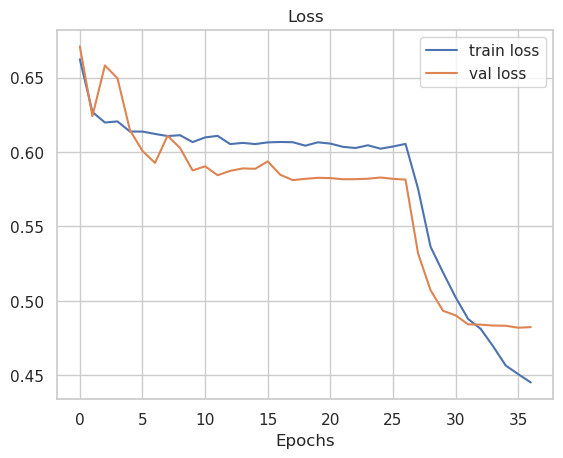

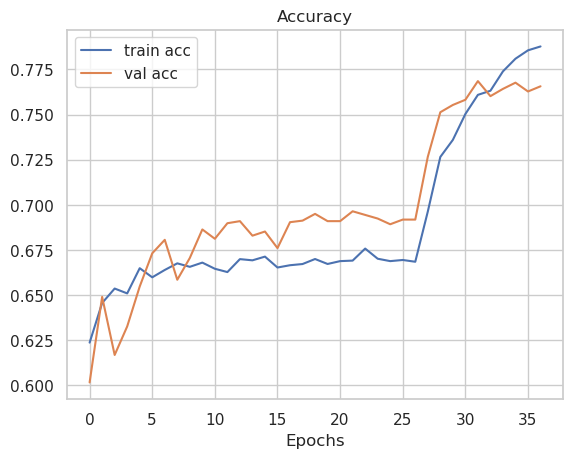

In [22]:
# ============================================
# Stage 1 → Stage 2 Training with History Dump
# ============================================
import os, joblib
import matplotlib.pyplot as plt
from tensorflow import keras

# ---------- Stage 1 ----------
hist_stage1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=cbs,
    verbose=1
)

print("\n--- Stage 1 completed, initiating Stage 2 ---\n")

# ---------- Unfreeze EfficientNet + BERT ----------
unfreeze_efficientnet_top(model, pct=0.35, freeze_bn=True)
ok = unfreeze_bert_last_n_smart(model, n=2)

print("--- Done with unfreezing, proceeding to compile ---")

# ---------- Recompile for fine-tuning ----------
model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss="binary_crossentropy",
    metrics=[keras.metrics.BinaryAccuracy(name="acc")]
)

print("\n--- Initiating Stage 2 training ---\n")

# ---------- Stage 2 ----------
hist_stage2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=cbs,
    verbose=1
)

# ---------- Save Histories ----------
os.makedirs("artifacts", exist_ok=True)
joblib.dump(hist_stage1.history, "artifacts/history_stage1.pkl")
joblib.dump(hist_stage2.history, "artifacts/history_stage2.pkl")
print("Training histories saved to 'artifacts/'")

# ---------- Plotting ----------
plt.figure()
plt.plot(hist_stage1.history["loss"] + hist_stage2.history["loss"], label="train loss")
plt.plot(hist_stage1.history["val_loss"] + hist_stage2.history["val_loss"], label="val loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

plt.figure()
plt.plot(hist_stage1.history["acc"] + hist_stage2.history["acc"], label="train acc")
plt.plot(hist_stage1.history["val_acc"] + hist_stage2.history["val_acc"], label="val acc")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()


## Building main model

### Designing Cross-Attention Block (CLS -> Image tokens)

In [22]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

class CrossAttentionBlock(keras.layers.Layer):
    """CLS (text) attends over image tokens."""
    def __init__(self, d_model=256, num_heads=4, ffn_mult=4, dropout=0.1, name=None):
        super().__init__(name=name)
        self.q_proj = layers.Dense(d_model)
        self.k_proj = layers.Dense(d_model)
        self.v_proj = layers.Dense(d_model)
        self.mha = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model//num_heads)
        self.dropout = layers.Dropout(dropout)
        self.ln1 = layers.LayerNormalization(epsilon=1e-6)
        self.ffn = keras.Sequential([
            layers.Dense(ffn_mult * d_model, activation="relu"),
            layers.Dropout(dropout),
            layers.Dense(d_model),
        ])
        self.ln2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, cls_vec, img_tokens, training=False):
        # cls_vec: (B, 1, d_t)  image tokens: (B, P, d_i)
        Q = self.q_proj(cls_vec)
        K = self.k_proj(img_tokens)
        V = self.v_proj(img_tokens)
        x = self.mha(query=Q, key=K, value=V, training=training)  # (B, 1, d_model)
        x = self.dropout(x, training=training)
        # Residual 1 (project CLS to d_model if needed)
        if cls_vec.shape[-1] != x.shape[-1]:
            cls_res = layers.Dense(x.shape[-1])(cls_vec)
        else:
            cls_res = cls_vec
        x = self.ln1(x + cls_res)

        # FFN + Residual 2
        y = self.ffn(x, training=training)
        y = self.dropout(y, training=training)
        y = self.ln2(x + y)  # (B, 1, d_model)
        return y  # keep as a single token


### Cross-Attention Model Builder

In [23]:
def build_crossatt_bert_effnet(
    img_shape=(224,224,3),
    preset="bert_base_en_uncased",
    seq_len=128,
    d_model=256,
    num_heads=4,
    ffn_mult=4,
    num_xatt_blocks=1,
    dropout=0.1
):
    # ----- Image branch -----
    img_in   = layers.Input(shape=img_shape, name="image")
    img_base = keras.applications.EfficientNetB0(include_top=False, input_shape=img_shape, weights="imagenet")
    img_base.trainable = False  # start frozen
    fmap = img_base(img_in, training=False)            # (B, H, W, C)
    tokens = layers.Reshape((-1, fmap.shape[-1]))(fmap)  # (B, P, C)
    img_proj = layers.Dense(d_model, name="img_proj")(tokens)  # (B, P, d_model)

    # ----- Text branch (KerasHub BERT) -----
    token_ids_in    = layers.Input(shape=(seq_len,), dtype="int32", name="token_ids")
    segment_ids_in  = layers.Input(shape=(seq_len,), dtype="int32", name="segment_ids")
    padding_mask_in = layers.Input(shape=(seq_len,), dtype="bool",  name="padding_mask")

    bert_in = {"token_ids": token_ids_in, "segment_ids": segment_ids_in, "padding_mask": padding_mask_in}
    bert = keras_hub.models.BertBackbone.from_preset(preset)
    bert.trainable = False
    bert_out = bert(bert_in)                                # dict
    cls = bert_out["pooled_output"]                         # (B, d_text) == CLS
    cls = layers.Dense(d_model, name="cls_proj")(cls)       # (B, d_model)
    cls = layers.Reshape((1, d_model))(cls)                 # (B, 1, d_model)

    # ----- Cross-Attention (CLS -> image tokens) -----
    x = cls
    for i in range(num_xatt_blocks):
        x = CrossAttentionBlock(d_model=d_model, num_heads=num_heads, ffn_mult=ffn_mult,
                                dropout=dropout, name=f"xatt_{i+1}")(x, img_proj)

    # ----- Head -----
    h = layers.Flatten()(x)                        # (B, d_model)
    h = layers.Dropout(dropout)(h)
    h = layers.Dense(256, activation="relu")(h)
    h = layers.BatchNormalization()(h)
    h = layers.Dropout(dropout)(h)
    out = layers.Dense(1, activation="sigmoid")(h)

    model = keras.Model(
        inputs={"image": img_in, "token_ids": token_ids_in, "segment_ids": segment_ids_in, "padding_mask": padding_mask_in},
        outputs=out,
        name="crossatt_bert_effnet_cls2img"
    )
    return model


### Stage wise training with existing callbacks

In [25]:
# Build cross-attention model (baseline+)
xatt_model = build_crossatt_bert_effnet(
    img_shape=(224,224,3),
    preset=PRESET,
    seq_len=SEQ_LEN,
    d_model=256,
    num_heads=4,
    ffn_mult=4,
    num_xatt_blocks=1,
    dropout=0.2
)

xatt_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=[keras.metrics.BinaryAccuracy(name="acc")]
)

# Stage 1: train with frozen backbones
# hist1 = xatt_model.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=cbs, verbose=1)

# Stage 2: unfreeze some EfficientNet + some BERT blocks; small LR
unfreeze_efficientnet_top(xatt_model, pct=0.35, freeze_bn=True)
unfreeze_bert_last_n_smart(xatt_model, n=2)
recompile_for_finetune(xatt_model, lr=1e-5)

# hist2 = xatt_model.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=cbs, verbose=1)


EfficientNet: set trainable on top 35% (~84/238 layers). BN frozen=True
BERT: set trainable on last 2/4 transformer_layers


In [26]:
import matplotlib.pyplot as plt
import pandas as pd

# --- Combine histories into one DataFrame ---
def merge_histories(h1, h2):
    h1_df = pd.DataFrame(h1.history)
    h2_df = pd.DataFrame(h2.history)
    h2_df.index += len(h1_df)  # continue epoch numbering
    return pd.concat([h1_df, h2_df])

hist_df = merge_histories(hist1, hist2)

# --- Plot training curves ---
plt.figure(figsize=(10,4))

# 1️. Accuracy
plt.subplot(1,2,1)
plt.plot(hist_df["acc"], label="train acc")
plt.plot(hist_df["val_acc"], label="val acc")
plt.axvline(len(hist1.history["acc"]) - 1, color="gray", linestyle="--", label="stage switch")
plt.title("Accuracy over epochs")
plt.xlabel("Epoch")
plt.ylabel("Binary Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)

# 2️. Loss
plt.subplot(1,2,2)
plt.plot(hist_df["loss"], label="train loss")
plt.plot(hist_df["val_loss"], label="val loss")
plt.axvline(len(hist1.history["loss"]) - 1, color="gray", linestyle="--")
plt.title("Loss over epochs")
plt.xlabel("Epoch")
plt.ylabel("Binary Crossentropy")
plt.legend()
plt.grid(True, alpha=0.3)

plt.suptitle("Cross-Attention Model Training (Stage 1 → Stage 2)", fontsize=13)
plt.tight_layout()
plt.show()


NameError: name 'hist1' is not defined

## Fine Tunning the model

In [ ]:
import random, numpy as np, os, joblib

SEARCH_SPACE = {
    "d_model":        [192, 256, 320],
    "num_heads":      [3, 4, 5, 8],
    "ffn_mult":       [2, 4],
    "num_xatt_blocks":[1, 2],
    "dropout":        [0.1, 0.2, 0.3],
    "lr_stage1":      [1e-3, 5e-4],
    "lr_stage2":      [2e-5, 1e-5],
    "unfreeze_pct":   [0.25, 0.35, 0.5],
    "bert_blocks":    [1, 2],
}

def sample_cfg():
    return {k: random.choice(v) for k, v in SEARCH_SPACE.items()}

def train_one_trial(cfg, trial_id):
    # Build
    m = build_crossatt_bert_effnet(
        img_shape=(224,224,3),
        preset=PRESET,
        seq_len=SEQ_LEN,
        d_model=cfg["d_model"],
        num_heads=cfg["num_heads"],
        ffn_mult=cfg["ffn_mult"],
        num_xatt_blocks=cfg["num_xatt_blocks"],
        dropout=cfg["dropout"]
    )
    # Stage 1
    m.compile(optimizer=keras.optimizers.Adam(cfg["lr_stage1"]),
              loss="binary_crossentropy",
              metrics=[keras.metrics.BinaryAccuracy(name="acc")])

    EPOCHS_TRIAL = 8  # keep small for speed; bump later
    cbs_trial = [
        keras.callbacks.EarlyStopping(monitor="val_acc", mode="max", patience=3, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor="val_acc", mode="max", factor=0.5, patience=2),
    ]
    hist1 = m.fit(train_ds, validation_data=val_ds, epochs=EPOCHS_TRIAL, callbacks=cbs_trial, verbose=0)

    # Stage 2
    unfreeze_efficientnet_top(m, pct=cfg["unfreeze_pct"], freeze_bn=True)
    unfreeze_bert_last_n_smart(m, n=cfg["bert_blocks"])
    m.compile(optimizer=keras.optimizers.Adam(cfg["lr_stage2"]),
              loss="binary_crossentropy",
              metrics=[keras.metrics.BinaryAccuracy(name="acc")])
    hist2 = m.fit(train_ds, validation_data=val_ds, epochs=EPOCHS_TRIAL, callbacks=cbs_trial, verbose=0)

    # Get best val_acc seen this trial
    best_val_acc = max(hist1.history.get("val_acc", [0]) + hist2.history.get("val_acc", [0]))
    return m, best_val_acc, {"hist1": hist1.history, "hist2": hist2.history}

# ----- Run random search -----
os.makedirs("artifacts", exist_ok=True)
N_TRIALS = 8  # increase as budget allows

best = {"score": -1, "cfg": None, "path": None}
for t in range(1, N_TRIALS+1):
    cfg = sample_cfg()
    model_t, score_t, hists = train_one_trial(cfg, t)
    print(f"[trial {t}] val_acc={score_t:.4f}  cfg={cfg}")

    if score_t > best["score"]:
        best["score"] = score_t
        best["cfg"] = cfg
        best_path = f"artifacts/best_crossatt_trial{t}.keras"
        model_t.save(best_path)
        best["path"] = best_path
        joblib.dump(hists, f"artifacts/best_crossatt_hist.pkl")
        joblib.dump(cfg,   f"artifacts/best_crossatt_cfg.pkl")
        print(f"  ↳ new best saved to {best_path}")

print("\nBest trial:")
print(best["cfg"])
print(f"Best val_acc: {best['score']:.4f}")
print(f"Saved model:  {best['path']}")


### Training model with fine tunned parameter 

In [ ]:
# ==============================
# 1) Load best config from search
# ==============================
import joblib, os
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt

best_cfg = joblib.load("artifacts/best_crossatt_cfg.pkl")
print("Best cfg:", best_cfg)

# (Optional) a distinct checkpoint name for the final run
final_ckpt = "artifacts/final_crossatt.keras"

# ==============================
# 2) Rebuild model with best cfg
# ==============================
final_model = build_crossatt_bert_effnet(
    img_shape=(224,224,3),
    preset=PRESET,
    seq_len=SEQ_LEN,
    d_model=best_cfg["d_model"],
    num_heads=best_cfg["num_heads"],
    ffn_mult=best_cfg["ffn_mult"],
    num_xatt_blocks=best_cfg["num_xatt_blocks"],
    dropout=best_cfg["dropout"]
)

# fresh callbacks (separate from search)
final_cbs = [
    keras.callbacks.ModelCheckpoint(final_ckpt, monitor="val_acc", mode="max", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_acc", mode="max", patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_acc", mode="max", factor=0.5, patience=2),
]

# ==============================
# 3) (Option A) Train on train/val as before
#    (Option B) Retrain on train+val together for a tiny extra gain:
#       trainval_ds = make_ds_bert(trainval_df, training=True, batch=32)
#       val_ds_small = make_ds_bert(val_df.sample(frac=0.1, random_state=SEED), training=False, batch=32)
#    Below uses the original train/val (Option A) for simplicity.
# ==============================
final_model.compile(optimizer=keras.optimizers.Adam(best_cfg["lr_stage1"]),
                    loss="binary_crossentropy",
                    metrics=[keras.metrics.BinaryAccuracy(name="acc")])

hist1 = final_model.fit(train_ds, validation_data=val_ds,
                        epochs=100, callbacks=final_cbs, verbose=1)

# Stage 2 fine-tune with best unfreezing plan
unfreeze_efficientnet_top(final_model, pct=best_cfg["unfreeze_pct"], freeze_bn=True)
unfreeze_bert_last_n_smart(final_model, n=best_cfg["bert_blocks"])
final_model.compile(optimizer=keras.optimizers.Adam(best_cfg["lr_stage2"]),
                    loss="binary_crossentropy",
                    metrics=[keras.metrics.BinaryAccuracy(name="acc")])

hist2 = final_model.fit(train_ds, validation_data=val_ds,
                        epochs=100, callbacks=final_cbs, verbose=1)

# Save histories
joblib.dump({"stage1": hist1.history, "stage2": hist2.history}, "artifacts/final_histories.pkl")

# ==============================
# 4) Plot training curves
# ==============================
def _concat(a, b, k):  # helper to join stage1+stage2 curves
    return a.get(k, []) + b.get(k, [])

h1, h2 = hist1.history, hist2.history

plt.figure()
plt.plot(_concat(h1, h2, "loss"), label="train loss")
plt.plot(_concat(h1, h2, "val_loss"), label="val loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Final Training Loss"); plt.legend(); plt.show()

plt.figure()
plt.plot(_concat(h1, h2, "acc"), label="train acc")
plt.plot(_concat(h1, h2, "val_acc"), label="val acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Final Training Accuracy"); plt.legend(); plt.show()

## Final Evaluation on Hold out Test data

In [ ]:
# ==============================
# 5) Final evaluation on TEST (once!)
# ==============================
test_ds = make_ds_bert(test_df, training=False, batch=32)

best_final = keras.models.load_model(final_ckpt)  # ensure we evaluate the best epoch
test_metrics = best_final.evaluate(test_ds, verbose=1)
print("TEST metrics:", dict(zip(best_final.metrics_names, test_metrics)))

# (Optional) predictions & thresholding for a report
# y_prob = best_final.predict(test_ds).ravel()
# y_pred = (y_prob >= 0.5).astype(int)
# y_true = np.concatenate([y for _, (_, y) in enumerate(test_ds)])  # depends on your ds structure

In [ ]:
# ==============================
# Predictions & thresholding (for report)
# ==============================
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import os, joblib

os.makedirs("artifacts", exist_ok=True)

# 1) Probabilities from the best checkpoint
y_prob = best_final.predict(test_ds, verbose=0).ravel()

# 2) Ground-truth labels from the dataset
#    Assumes test_ds yields (inputs_dict, label). Works for (B,1) or (B,) labels.
y_true = []
for batch in test_ds:
    # batch = (x, y)
    y = batch[1]
    y = tf.reshape(y, [-1]).numpy()
    y_true.append(y)
y_true = np.concatenate(y_true, axis=0).astype(int)

# 3) Default threshold @ 0.5 (balanced data, simple & standard)
y_pred = (y_prob >= 0.5).astype(int)

# 4) Metrics
acc = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary")

print({
    "acc": round(acc, 4),
    "precision": round(prec, 4),
    "recall": round(rec, 4),
    "f1": round(f1, 4),
})

# 5) Confusion matrix (save figure)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Entailed", "Entailed"])
disp.plot(values_format="d")
plt.title("Confusion Matrix — Test")
plt.tight_layout()
plt.savefig("artifacts/confusion_matrix_test.png", dpi=160)
plt.show()

# 6) (Optional) Save predictions for appendix/repro
np.savez_compressed("artifacts/test_preds_crossatt.npz", y_true=y_true, y_prob=y_prob, y_pred=y_pred)
joblib.dump({"acc": acc, "precision": prec, "recall": rec, "f1": f1}, "artifacts/test_metrics.pkl")
